<a href="https://colab.research.google.com/github/harunkurtdev/ayvos_staj/blob/master/dinov2-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

First, let's import the packages we will need for this project.

In [9]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
import cv2
import json
import glob
from tqdm.notebook import tqdm

In [10]:
!pip install roboflow supervision -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.3 MB/s eta 0:00:00


In [11]:
import roboflow
import supervision as sv

roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("popular-benchmarks").project("mit-indoor-scene-recognition")
dataset = project.version(5).download("folder")

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MIT-Indoor-Scene-Recognition-5 in folder:: 100%|██████████| 15712/15712 [00:02<00:00, 6152.26it/s]


In [14]:
cwd = os.getcwd()

ROOT_DIR = os.path.join(cwd, "MIT-Indoor-Scene-Recognition-5/train")

labels = {}

for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".jpg"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder

files = labels.keys()

In [15]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

dinov2_vits14.to(device)

#transform_image = T.Compose([T.ToTensor(), T.Resize(244), T.CenterCrop(224), T.Normalize([0.5], [0.5])])

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [16]:
def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    # **Use bicubic interpolation for smoother transitions**
    transform_image = T.Compose([
        T.ToTensor(),
        T.Resize(244, interpolation=T.InterpolationMode.BICUBIC),  # **Change here**
        T.CenterCrop(224),
        T.Normalize([0.5], [0.5])
    ])

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

def compute_embeddings(files: list) -> dict:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = {}

    with torch.no_grad():
      for i, file in enumerate(tqdm(files)):
        embeddings = dinov2_vits14(load_image(file).to(device))

        all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings

In [17]:
embeddings = compute_embeddings(files)

  0%|          | 0/10885 [00:00<?, ?it/s]

In [21]:
from sklearn import svm

clf = svm.SVC(gamma='scale')

y = [labels[file] for file in files]

embedding_list = list(embeddings.values())

# clf.fit(np.array(embedding_list).reshape(-1, 384), y)

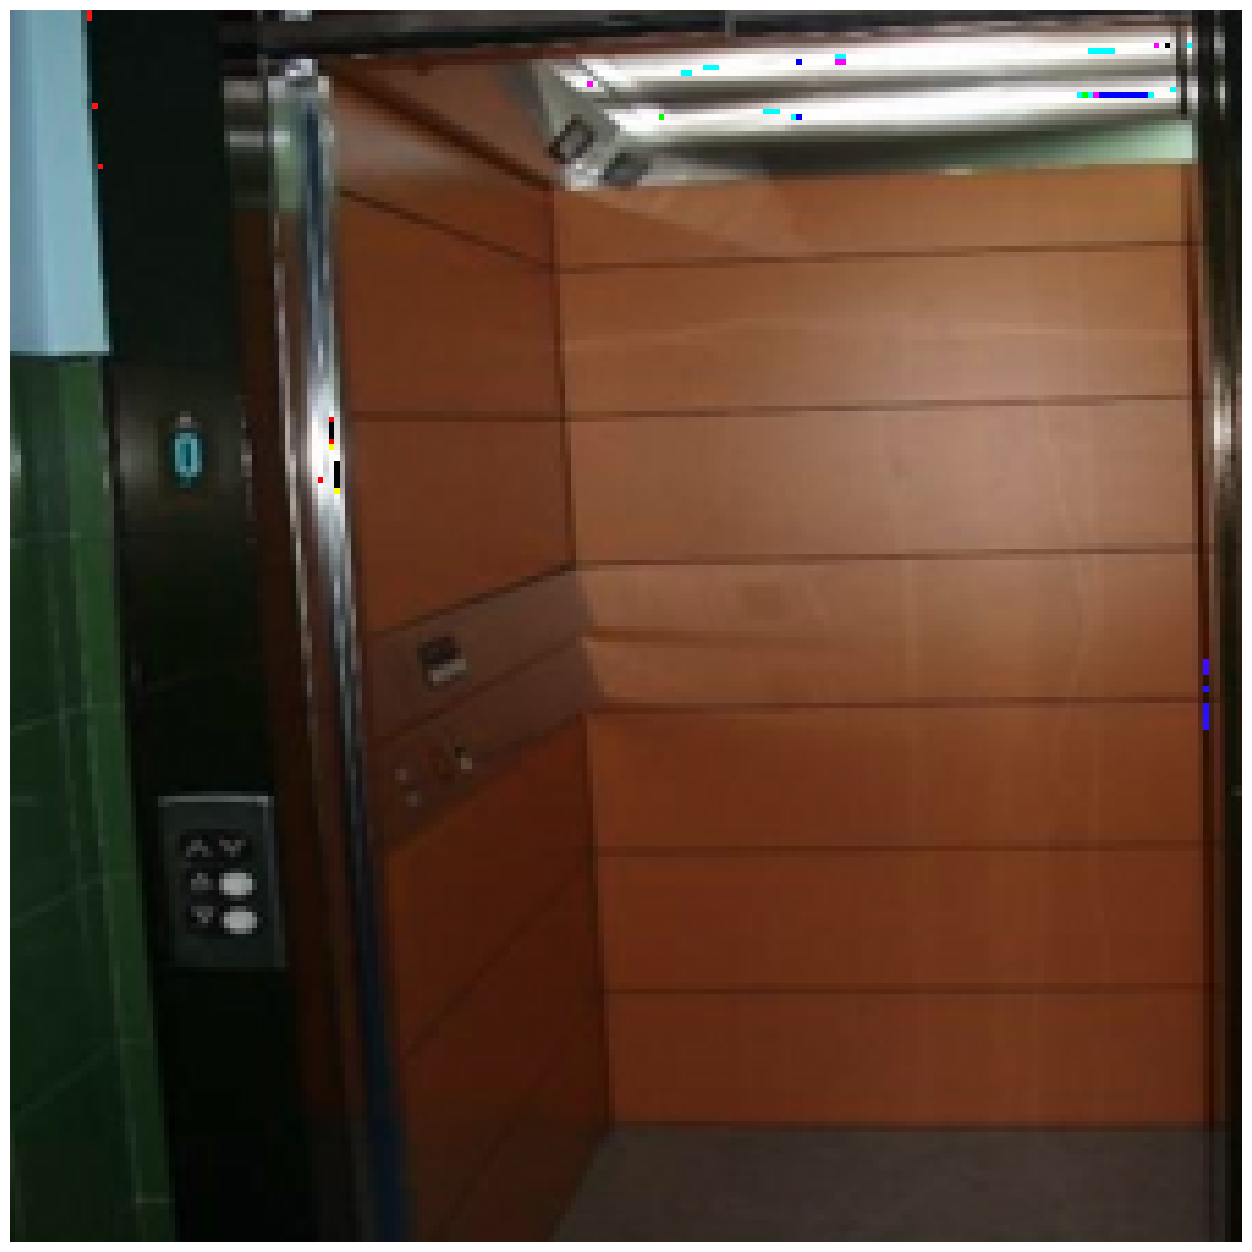


Predicted class: elevator


In [9]:
input_file = "MIT-Indoor-Scene-Recognition-5/test/elevator/elevator_google_0053_jpg.rf.41487c3b9c1690a5de26ee0218452627.jpg"

new_image = load_image(input_file)

%matplotlib inline
#sv.plot_image(image=new_image, size=(16, 16))

# Convert the PyTorch tensor to a NumPy array and then to the correct data type
#new_image_np = new_image.cpu().numpy().squeeze()
#new_image_np = new_image_np.transpose((1, 2, 0))
#new_image_np = (new_image_np * 255).astype(np.uint8)


new_image_np = new_image.cpu().numpy().squeeze()
new_image_np = new_image_np.transpose((1, 2, 0))


new_image_np = (new_image_np * 0.5 + 0.5) * 255  # Reverse normalization
new_image_np = new_image_np.astype(np.uint8)


%matplotlib inline
# Use the converted NumPy array for plotting
sv.plot_image(image=new_image_np, size=(16, 16))

with torch.no_grad():
    embedding = dinov2_vits14(new_image.to(device))

    prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))

    print()
    print("Predicted class: " + prediction[0])

In [1]:
!pip install transformers


In [4]:
from transformers import CLIPProcessor, CLIPModel
import torch.nn.functional as F

import torch
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")


# CLIP yükle
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [5]:
def compute_embeddings_with_clip(files: list) -> dict:
    all_embeddings = {}

    with torch.no_grad():
        for i, file in enumerate(tqdm(files)):
            # Load and transform image
            image = load_image(file).to(device)

            # DINOv2
            dino_emb = dinov2_vits14(image)
            dino_emb = F.normalize(dino_emb, dim=-1)

            # CLIP
            clip_inputs = clip_processor(images=Image.open(file).convert("RGB"), return_tensors="pt").to(device)
            clip_emb = clip_model.get_image_features(**clip_inputs)
            clip_emb = F.normalize(clip_emb, dim=-1)

            # Combine
            combined = torch.cat([clip_emb, dino_emb], dim=-1)
            combined = F.normalize(combined, dim=-1)

            all_embeddings[file] = combined.cpu().numpy().tolist()

    with open("all_embeddings_combined.json", "w") as f:
        json.dump(all_embeddings, f)

    return all_embeddings


In [22]:
# Yeni embedding'leri al
embeddings = compute_embeddings_with_clip(files)

# SVM ile eğit
embedding_list = list(embeddings.values())


  0%|          | 0/10885 [00:00<?, ?it/s]

ValueError: cannot reshape array of size 9752960 into shape (1536)

In [24]:
embedding_list = [np.array(e).squeeze() for e in list(embeddings.values())]
clf.fit(np.array(embedding_list), y)

SVC()

In [25]:
def predict_scene(image_path):
    image = load_image(image_path).to(device)

    with torch.no_grad():
        dino_emb = dinov2_vits14(image)
        dino_emb = F.normalize(dino_emb, dim=-1)

        clip_inputs = clip_processor(images=Image.open(image_path).convert("RGB"), return_tensors="pt").to(device)
        clip_emb = clip_model.get_image_features(**clip_inputs)
        clip_emb = F.normalize(clip_emb, dim=-1)

        combined = torch.cat([clip_emb, dino_emb], dim=-1)
        combined = F.normalize(combined, dim=-1)

    prediction = clf.predict(combined.cpu().numpy().reshape(1, -1))
    return prediction[0]


In [28]:
image_path = "MIT-Indoor-Scene-Recognition-5/test/elevator/elevator_google_0053_jpg.rf.41487c3b9c1690a5de26ee0218452627.jpg"
predicted_label = predict_scene(image_path)
print("Tahmin edilen sınıf:", predicted_label)


Tahmin edilen sınıf: elevator


In [29]:
image_path = "kapak_171849.jpg"
predicted_label = predict_scene(image_path)
print("Tahmin edilen sınıf:", predicted_label)

Tahmin edilen sınıf: grocerystore
